In [406]:
import pandas as pd
import geopandas as gp
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as pl
%pylab inline
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Loading Census data
data_census = pd.read_csv('Census_2010.csv')

In [3]:
data_census.head()

,Zipcode,Sex,Total,White,Black,Asian,Hispanic,Mixed Non-Hispanic
0,10001,Female,10918,5929,745,1987,1913,265
1,10001,Male,10184,5775,857,1532,1735,231
2,10002,Female,42840,8032,2906,19675,11472,624
3,10002,Male,38570,8298,2351,18064,9147,576
4,10003,Female,29274,20677,788,4620,2223,825


In [4]:
#Renaming ZipCode column
data_census = data_census.rename(columns = {'Zipcode':'ZipCode'})

In [5]:
#Loading 311 data
data_311 = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv')
data_311 = data_311.rename(columns = {'Incident Zip':'ZipCode'})

In [7]:
#Loading MapPLUTO data
data_MNpluto = data = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
data_BKpluto = data = gp.GeoDataFrame.from_file("Brooklyn/BKMapPLUTO.shp")

In [8]:
#Concatenating Manhattan and Brooklyn
data_mappluto =  gp.GeoDataFrame(pd.concat([data_MNpluto, data_BKpluto], ignore_index=True))

In [315]:
data_BKpluto.keys()

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [317]:
#Grouping MapPLUTO data by ZIP code and summing
res_mappluto = pd.DataFrame(data_mappluto[['UnitsRes', 'UnitsTotal']].groupby(data_mappluto['ZipCode']).sum())
res_mappluto['ZipCode'] = res_mappluto.index
res_mappluto.index = range(0,len(res_mappluto))
res_mappluto

,UnitsRes,UnitsTotal,ZipCode
0,0,12,0
1,17940,30253,10001
2,34505,40627,10002
3,33598,38201,10003
4,2409,3203,10004
5,5567,7041,10005
6,2704,3162,10006
7,3732,5225,10007
8,33130,34573,10009
9,19835,24305,10010


In [318]:
#Grouping MapPLUTO data by ZIP code and calculating mean of land value
land_mappluto = pd.DataFrame(data_mappluto['NumFloors'].groupby(data_mappluto['ZipCode']).mean())
land_mappluto['ZipCode'] = land_mappluto.index
land_mappluto.index = range(0,len(land_mappluto))
land_mappluto

,NumFloors,ZipCode
0,0.031856,0
1,7.208730,10001
2,4.840788,10002
3,5.741582,10003
4,14.263393,10004
5,20.226974,10005
6,13.250000,10006
7,10.197368,10007
8,4.498869,10009
9,7.942058,10010


In [32]:
#Combining genders for Census data
grouped_census = data_census.groupby(['ZipCode']).sum()
grouped_census['ZipCode'] = grouped_census.index
grouped_census.index = range(0,len(grouped_census))
grouped_census

,Total,White,Black,Asian,Hispanic,Mixed Non-Hispanic,ZipCode
0,21102,11704,1602,3519,3648,496,10001
1,81410,16330,5257,37739,20619,1200,10002
2,56024,40056,1738,8020,4489,1437,10003
3,3089,2034,86,653,189,108,10004
4,7135,4663,229,1472,530,196,10005
5,3011,1947,135,590,248,83,10006
6,6988,4715,413,870,711,236,10007
7,61347,30587,4775,8277,15977,1390,10009
8,31834,21665,1678,4553,3015,762,10010
9,50984,37300,1976,4475,5851,1129,10011


In [69]:
#Joining Census data to 311 data
data_311census = pd.merge(data_311, grouped_census, how='left', on=['ZipCode'])
data_311census

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,ZipCode,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Latitude,Longitude,Location,Total,White,Black,Asian,Hispanic,Mixed Non-Hispanic
0,19503049,12/31/2010 11:59:12 PM,01/01/2011 02:14:44 AM,NYPD,New York City Police Department,Blocked Driveway,11212,BROOKLYN,1008500,181726,40.665439,-73.912589,"(40.665439409429055, -73.91258883811614)",84500,666,67801,588,13905,1034
1,19503621,12/31/2010 11:57:30 PM,01/01/2011 12:46:41 AM,NYPD,New York City Police Department,Blocked Driveway,11365,QUEENS,1037441,205363,40.730191,-73.808082,"(40.73019074217415, -73.80808214665396)",42252,14064,3421,17532,6094,930
2,19504838,12/31/2010 11:54:59 PM,01/01/2011 08:03:26 AM,NYPD,New York City Police Department,Blocked Driveway,11236,BROOKLYN,1006381,176021,40.649786,-73.920246,"(40.64978599344521, -73.9202456701406)",93877,5066,77175,2319,7358,1396
3,19506107,12/31/2010 11:54:00 PM,03/16/2011 09:36:00 AM,DOT,Department of Transportation,Street Light Condition,10006,MANHATTAN,980807,197440,40.708603,-74.012419,"(40.70860327698897, -74.01241861690464)",3011,1947,135,590,248,83
4,19507090,12/31/2010 11:52:00 PM,02/01/2011 12:45:00 PM,DEP,Department of Environmental Protection,Noise,11209,BROOKLYN,978741,169492,40.631891,-74.019848,"(40.63189122768689, -74.01984766770063)",68853,47714,1173,7889,10322,1419
5,19504837,12/31/2010 11:50:45 PM,01/01/2011 02:10:59 AM,NYPD,New York City Police Department,Blocked Driveway,11368,QUEENS,1021079,214444,40.755199,-73.867068,"(40.755199052630154, -73.86706786330053)",109931,5777,10411,10834,81093,973
6,19502935,12/31/2010 11:48:11 PM,01/01/2011 03:39:55 AM,NYPD,New York City Police Department,Illegal Parking,10003,MANHATTAN,987254,202897,40.723582,-73.989162,"(40.723581595109145, -73.98916238466072)",56024,40056,1738,8020,4489,1437
7,19506202,12/31/2010 11:48:00 PM,01/01/2011 01:35:00 AM,DOT,Department of Transportation,Traffic Signal Condition,11228,BROOKLYN,981784,162247,40.612007,-74.008882,"(40.61200658490669, -74.00888178783936)",41788,26390,201,10182,4472,446
8,19506287,12/31/2010 11:48:00 PM,12/31/2010 11:48:00 PM,DSNY,BCC - Queens East,Snow,11422,QUEENS,1059628,181045,40.663283,-73.728302,"(40.66328256317842, -73.72830206247659)",30425,1475,24740,628,2657,573
9,19507089,12/31/2010 11:44:00 PM,01/03/2011 03:36:00 PM,DEP,Department of Environmental Protection,Noise,11235,BROOKLYN,995108,151042,40.581245,-73.960911,"(40.581244814092614, -73.96091077190891)",79132,58274,1492,10097,7900,1035


In [80]:
data_311census['ZipCode'] = data_311census['ZipCode'].astype(str).convert_objects(convert_numeric=True)
data_311census['ZipCode'].dtype

dtype('float64')

In [319]:
data_311censusres = pd.merge(data_311census, res_mappluto, how='left', on=['ZipCode'])
data_311censusres


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,ZipCode,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),...,Longitude,Location,Total,White,Black,Asian,Hispanic,Mixed Non-Hispanic,UnitsRes,UnitsTotal
0,19503049,12/31/2010 11:59:12 PM,01/01/2011 02:14:44 AM,NYPD,New York City Police Department,Blocked Driveway,11212,BROOKLYN,1008500,181726,...,-73.912589,"(40.665439409429055, -73.91258883811614)",84500,666,67801,588,13905,1034,33002,34715
1,19503621,12/31/2010 11:57:30 PM,01/01/2011 12:46:41 AM,NYPD,New York City Police Department,Blocked Driveway,11365,QUEENS,1037441,205363,...,-73.808082,"(40.73019074217415, -73.80808214665396)",42252,14064,3421,17532,6094,930,NaN,NaN
2,19504838,12/31/2010 11:54:59 PM,01/01/2011 08:03:26 AM,NYPD,New York City Police Department,Blocked Driveway,11236,BROOKLYN,1006381,176021,...,-73.920246,"(40.64978599344521, -73.9202456701406)",93877,5066,77175,2319,7358,1396,30762,32101
3,19506107,12/31/2010 11:54:00 PM,03/16/2011 09:36:00 AM,DOT,Department of Transportation,Street Light Condition,10006,MANHATTAN,980807,197440,...,-74.012419,"(40.70860327698897, -74.01241861690464)",3011,1947,135,590,248,83,2704,3162
4,19507090,12/31/2010 11:52:00 PM,02/01/2011 12:45:00 PM,DEP,Department of Environmental Protection,Noise,11209,BROOKLYN,978741,169492,...,-74.019848,"(40.63189122768689, -74.01984766770063)",68853,47714,1173,7889,10322,1419,32605,34486
5,19504837,12/31/2010 11:50:45 PM,01/01/2011 02:10:59 AM,NYPD,New York City Police Department,Blocked Driveway,11368,QUEENS,1021079,214444,...,-73.867068,"(40.755199052630154, -73.86706786330053)",109931,5777,10411,10834,81093,973,NaN,NaN
6,19502935,12/31/2010 11:48:11 PM,01/01/2011 03:39:55 AM,NYPD,New York City Police Department,Illegal Parking,10003,MANHATTAN,987254,202897,...,-73.989162,"(40.723581595109145, -73.98916238466072)",56024,40056,1738,8020,4489,1437,33598,38201
7,19506202,12/31/2010 11:48:00 PM,01/01/2011 01:35:00 AM,DOT,Department of Transportation,Traffic Signal Condition,11228,BROOKLYN,981784,162247,...,-74.008882,"(40.61200658490669, -74.00888178783936)",41788,26390,201,10182,4472,446,15763,16453
8,19506287,12/31/2010 11:48:00 PM,12/31/2010 11:48:00 PM,DSNY,BCC - Queens East,Snow,11422,QUEENS,1059628,181045,...,-73.728302,"(40.66328256317842, -73.72830206247659)",30425,1475,24740,628,2657,573,NaN,NaN
9,19507089,12/31/2010 11:44:00 PM,01/03/2011 03:36:00 PM,DEP,Department of Environmental Protection,Noise,11235,BROOKLYN,995108,151042,...,-73.960911,"(40.581244814092614, -73.96091077190891)",79132,58274,1492,10097,7900,1035,37303,39370


In [320]:
data_311censusres['ResDensity'] = data_311censusres['Total']/data_311censusres['UnitsRes']

In [321]:
data_311censusres

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,ZipCode,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),...,Location,Total,White,Black,Asian,Hispanic,Mixed Non-Hispanic,UnitsRes,UnitsTotal,ResDensity
0,19503049,12/31/2010 11:59:12 PM,01/01/2011 02:14:44 AM,NYPD,New York City Police Department,Blocked Driveway,11212,BROOKLYN,1008500,181726,...,"(40.665439409429055, -73.91258883811614)",84500,666,67801,588,13905,1034,33002,34715,2.560451
1,19503621,12/31/2010 11:57:30 PM,01/01/2011 12:46:41 AM,NYPD,New York City Police Department,Blocked Driveway,11365,QUEENS,1037441,205363,...,"(40.73019074217415, -73.80808214665396)",42252,14064,3421,17532,6094,930,NaN,NaN,NaN
2,19504838,12/31/2010 11:54:59 PM,01/01/2011 08:03:26 AM,NYPD,New York City Police Department,Blocked Driveway,11236,BROOKLYN,1006381,176021,...,"(40.64978599344521, -73.9202456701406)",93877,5066,77175,2319,7358,1396,30762,32101,3.051720
3,19506107,12/31/2010 11:54:00 PM,03/16/2011 09:36:00 AM,DOT,Department of Transportation,Street Light Condition,10006,MANHATTAN,980807,197440,...,"(40.70860327698897, -74.01241861690464)",3011,1947,135,590,248,83,2704,3162,1.113536
4,19507090,12/31/2010 11:52:00 PM,02/01/2011 12:45:00 PM,DEP,Department of Environmental Protection,Noise,11209,BROOKLYN,978741,169492,...,"(40.63189122768689, -74.01984766770063)",68853,47714,1173,7889,10322,1419,32605,34486,2.111731
5,19504837,12/31/2010 11:50:45 PM,01/01/2011 02:10:59 AM,NYPD,New York City Police Department,Blocked Driveway,11368,QUEENS,1021079,214444,...,"(40.755199052630154, -73.86706786330053)",109931,5777,10411,10834,81093,973,NaN,NaN,NaN
6,19502935,12/31/2010 11:48:11 PM,01/01/2011 03:39:55 AM,NYPD,New York City Police Department,Illegal Parking,10003,MANHATTAN,987254,202897,...,"(40.723581595109145, -73.98916238466072)",56024,40056,1738,8020,4489,1437,33598,38201,1.667480
7,19506202,12/31/2010 11:48:00 PM,01/01/2011 01:35:00 AM,DOT,Department of Transportation,Traffic Signal Condition,11228,BROOKLYN,981784,162247,...,"(40.61200658490669, -74.00888178783936)",41788,26390,201,10182,4472,446,15763,16453,2.651018
8,19506287,12/31/2010 11:48:00 PM,12/31/2010 11:48:00 PM,DSNY,BCC - Queens East,Snow,11422,QUEENS,1059628,181045,...,"(40.66328256317842, -73.72830206247659)",30425,1475,24740,628,2657,573,NaN,NaN,NaN
9,19507089,12/31/2010 11:44:00 PM,01/03/2011 03:36:00 PM,DEP,Department of Environmental Protection,Noise,11235,BROOKLYN,995108,151042,...,"(40.581244814092614, -73.96091077190891)",79132,58274,1492,10097,7900,1035,37303,39370,2.121331


In [323]:
data_noise = data_311censusres[(data_311censusres['Complaint Type'].str.contains('Noise')) & np.isfinite(data_311censusres['ResDensity']) & (data_311censusres['ResDensity']<10)] 

In [324]:
noise_count = data_noise.groupby('ZipCode').count()
noise_count['ZipCode'] = noise_count.index
noise_count.index = range(0,len(noise_count))

In [325]:
noise_count1 = noise_count[['ZipCode','Unique Key']]
noise_count1 = noise_count1.rename(columns = {'Unique Key':'Count'})
noise_count1

,ZipCode,Count
0,10001,814
1,10002,1759
2,10003,2070
3,10004,113
4,10005,182
5,10006,164
6,10007,312
7,10009,1824
8,10010,597
9,10011,1631


In [328]:
data_noise1 = data_noise[['ZipCode','Total','White','Black','Asian','Hispanic','Mixed Non-Hispanic','ResDensity', 'UnitsRes', 'UnitsTotal']]
noise_db = pd.merge(noise_count1, data_noise1, how='left', on=['ZipCode'])
noise_db = pd.merge(noise_db, land_mappluto, how='left', on=['ZipCode'])
noise_db

,ZipCode,Count,Total,White,Black,Asian,Hispanic,Mixed Non-Hispanic,ResDensity,UnitsRes,UnitsTotal,NumFloors
0,10001,814,21102,11704,1602,3519,3648,496,1.176254,17940,30253,7.208730
1,10001,814,21102,11704,1602,3519,3648,496,1.176254,17940,30253,7.208730
2,10001,814,21102,11704,1602,3519,3648,496,1.176254,17940,30253,7.208730
3,10001,814,21102,11704,1602,3519,3648,496,1.176254,17940,30253,7.208730
4,10001,814,21102,11704,1602,3519,3648,496,1.176254,17940,30253,7.208730
5,10001,814,21102,11704,1602,3519,3648,496,1.176254,17940,30253,7.208730
6,10001,814,21102,11704,1602,3519,3648,496,1.176254,17940,30253,7.208730
7,10001,814,21102,11704,1602,3519,3648,496,1.176254,17940,30253,7.208730
8,10001,814,21102,11704,1602,3519,3648,496,1.176254,17940,30253,7.208730
9,10001,814,21102,11704,1602,3519,3648,496,1.176254,17940,30253,7.208730


In [481]:
noise_db = noise_db.drop_duplicates(cols='ZipCode', take_last=True)
noise_db.index = range(0,len(noise_db))
noise_db['Noise per capita'] = noise_db['Count']/noise_db['Total']*1000
noise_db['Noise per unit'] = noise_db['Count']/noise_db['UnitsRes']*1000
noise_db['Res/Total'] = noise_db['UnitsRes']/noise_db['UnitsTotal']
noise_db['White_p'] = noise_db['White']/noise_db['Total']
noise_db

,ZipCode,Count,Total,White,Black,Asian,Hispanic,Mixed Non-Hispanic,ResDensity,UnitsRes,UnitsTotal,NumFloors,Noise per capita,Noise per unit,Res/Total,Black_p,White_p,Hispanic_p,Asian_p
0,10001,814,21102,11704,1602,3519,3648,496,1.176254,17940,30253,7.208730,38.574543,45.373467,0.592999,0.075917,0.554639,0.172875,0.166761
1,10002,1759,81410,16330,5257,37739,20619,1200,2.359368,34505,40627,4.840788,21.606682,50.978119,0.849312,0.064574,0.200590,0.253274,0.463567
2,10003,2070,56024,40056,1738,8020,4489,1437,1.667480,33598,38201,5.741582,36.948451,61.610810,0.879506,0.031022,0.714979,0.080126,0.143153
3,10004,113,3089,2034,86,653,189,108,1.282275,2409,3203,14.263393,36.581418,46.907430,0.752107,0.027841,0.658466,0.061185,0.211395
4,10005,182,7135,4663,229,1472,530,196,1.281660,5567,7041,20.226974,25.508059,32.692653,0.790655,0.032095,0.653539,0.074282,0.206307
5,10006,164,3011,1947,135,590,248,83,1.113536,2704,3162,13.250000,54.466955,60.650888,0.855155,0.044836,0.646629,0.082365,0.195948
6,10007,312,6988,4715,413,870,711,236,1.872454,3732,5225,10.197368,44.647968,83.601286,0.714258,0.059101,0.674728,0.101746,0.124499
7,10009,1824,61347,30587,4775,8277,15977,1390,1.851705,33130,34573,4.498869,29.732505,55.055841,0.958262,0.077836,0.498590,0.260437,0.134921
8,10010,597,31834,21665,1678,4553,3015,762,1.604941,19835,24305,7.942058,18.753534,30.098311,0.816087,0.052711,0.680562,0.094710,0.143023
9,10011,1631,50984,37300,1976,4475,5851,1129,1.448409,35200,39085,5.216266,31.990428,46.335227,0.900601,0.038757,0.731602,0.114761,0.087773


In [449]:
#Estimating linear model

X1 = noise_db['Res/Total']
Y1 = noise_db['Noise per capita']

model1 = sm.OLS(Y1, sm.add_constant(X1), mising='drop').fit()
print model1.summary()
print model1.params

                            OLS Regression Results                            
Dep. Variable:       Noise per capita   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     69.94
Date:                Wed, 11 Nov 2015   Prob (F-statistic):           1.71e-12
Time:                        15:46:52   Log-Likelihood:                -299.85
No. Observations:                  81   AIC:                             603.7
Df Residuals:                      79   BIC:                             608.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        100.6476      9.905     10.161      0.0

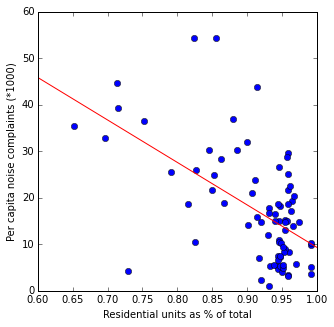

In [372]:
fig = figure(figsize = (5, 5))
plot(X1, Y1, 'o')
XLR1 = arange(0, 2, 0.1)
YLR1 = model1.params[1]*XLR1+model1.params[0]
pl.plot(XLR1, YLR1, 'red')
ylim(0,60)
xlim(0.6,1)
plt.ylabel('Per capita noise complaints (*1000)')
plt.xlabel('Residential units as % of total')

In [353]:
model2 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': noise_db['Res/Total'],'Y': noise_db['Noise per capita']}).fit()
print model2.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     34.68
Date:                Wed, 11 Nov 2015   Prob (F-statistic):           1.68e-11
Time:                        13:32:59   Log-Likelihood:                -299.76
No. Observations:                  81   AIC:                             605.5
Df Residuals:                      78   BIC:                             612.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      89.0797     30.803      2.892      

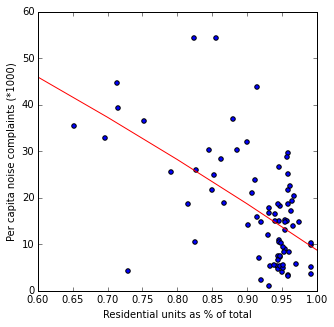

In [386]:
secdegree1 = np.polyfit(X1, Y1, 2)
fig = pl.figure(figsize=(5, 5))
pl.scatter(X1, Y1)
XLR2 = arange(0, 2, 0.1)
YLR2 = secdegree1[0]*XLR2**2+secdegree1[1]*XLR2+secdegree1[2]
pl.plot(XLR2, YLR2, 'red')
ylim(0,60)
xlim(0.6,1)
plt.ylabel('Per capita noise complaints (*1000)')
plt.xlabel('Residential units as % of total')

In [367]:
–#Estimating linear model

X2 = noise_db['NumFloors']
Y2 = noise_db['Noise per capita']

model3 = sm.OLS(Y2, sm.add_constant(X2), mising='drop').fit()
print model3.summary()
print model3.params

                            OLS Regression Results                            
Dep. Variable:       Noise per capita   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     10.76
Date:                Wed, 11 Nov 2015   Prob (F-statistic):            0.00155
Time:                        13:43:27   Log-Likelihood:                -320.36
No. Observations:                  81   AIC:                             644.7
Df Residuals:                      79   BIC:                             649.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         12.6643      2.235      5.666      0.0

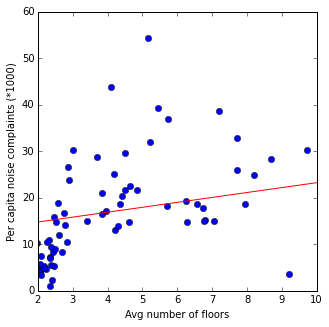

In [385]:
fig = figure(figsize = (5, 5))
plot(X2, Y2, 'o')
XLR3 = arange(0, 50, 0.1)
YLR3 = model3.params[1]*XLR3+model3.params[0]
pl.plot(XLR3, YLR3, 'red')
ylim(0,60)
xlim(2,10)
plt.ylabel('Per capita noise complaints (*1000)')
plt.xlabel('Avg number of floors')

In [375]:
model4 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': noise_db['NumFloors'],'Y': noise_db['Noise per capita']}).fit()
print model4.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     26.99
Date:                Wed, 11 Nov 2015   Prob (F-statistic):           1.23e-09
Time:                        13:54:52   Log-Likelihood:                -304.23
No. Observations:                  81   AIC:                             614.5
Df Residuals:                      78   BIC:                             621.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      -2.2422      3.036     -0.738      

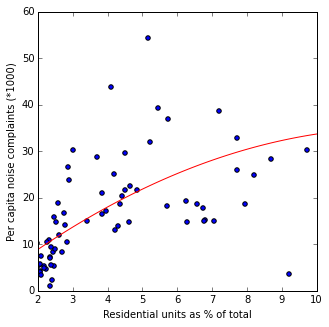

In [558]:
secdegree2 = np.polyfit(X2, Y2, 2)
fig = pl.figure(figsize=(5, 5))
pl.scatter(X2, Y2)
XLR4 = arange(0, 50, 0.1)
YLR4 = secdegree2[0]*XLR4**2+secdegree2[1]*XLR4+secdegree2[2]
pl.plot(XLR4, YLR4, 'red')
ylim(0,60)
xlim(2,10)
plt.ylabel('Per capita noise complaints (*1000)')
plt.xlabel('Residential units as % of total')

In [559]:
noise_db['Noise per capita']

0     38.574543
1     21.606682
2     36.948451
3     36.581418
4     25.508059
5     54.466955
6     44.647968
7     29.732505
8     18.753534
9     31.990428
10    54.420922
11    39.241877
12    43.899997
13    25.930642
14    35.475113
15    71.332951
16    28.318171
17    15.012262
18    30.353339
19    15.180826
20    18.268306
21    19.238901
22    20.321736
23    16.580970
24    18.652666
25    12.999487
26    17.148783
27    25.160353
28    21.698557
29    18.747914
        ...    
51    10.834677
52     4.757451
53    23.902260
54     4.082840
55     5.426004
56     4.975742
57    16.696069
58    10.420502
59    30.266715
60     7.351768
61     2.396417
62     7.068415
63     8.238798
64    18.898576
65     5.448934
66     5.753764
67     8.956695
68     8.319222
69     3.398105
70    10.385163
71     5.508749
72    14.698824
73    10.507695
74     9.380639
75     6.574974
76     7.443259
77     3.227628
78    15.792849
79    26.714303
80     1.045322
Name: Noise per capita, 

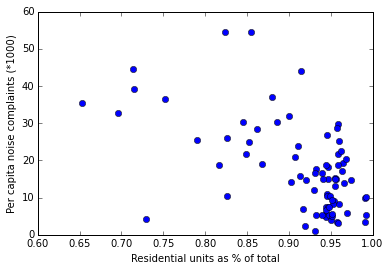

In [560]:
x = noise_db['Res/Total']
y = noise_db['Noise per capita']
pl.plot(x, y, 'o')
ylim(0,60)
xlim(0.6,1)
plt.ylabel('Per capita noise complaints (*1000)')
plt.xlabel('Residential units as % of total')

In [561]:
X = np.append(x, y).reshape(2,81).transpose()

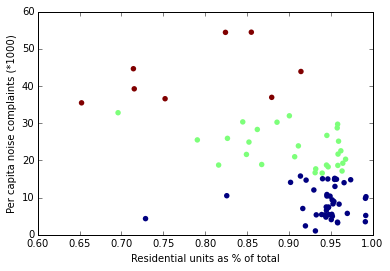

In [565]:
# try clustering with k=3 first
est=KMeans(n_clusters=3,n_init=100)
est.fit(X)
labels=est.labels_
plt.figure(figsize=(6,4))
plt.scatter (x,y,s=30,c=labels.astype(np.float),lw=0)
ylim(0,60)
xlim(0.6,1)
plt.ylabel('Per capita noise complaints (*1000)')
plt.xlabel('Residential units as % of total')

2 clusters: 0.622630163135
3 clusters: 0.551145736169
4 clusters: 0.597010611574
5 clusters: 0.61046343836
6 clusters: 0.613274931817
7 clusters: 0.560806355066
8 clusters: 0.564998716226
9 clusters: 0.58394384468
10 clusters: 0.604058808265
11 clusters: 0.581763667033
Best for 2 clusters: 0.622630163135


(0.6, 1)

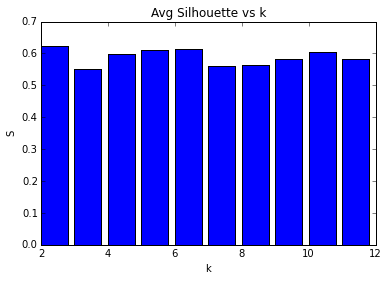

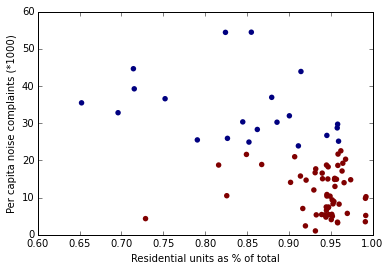

In [567]:
s=[0]*10
for k in range(0,10):
    est=KMeans(n_clusters=k+2,n_init=25)
    est.fit(X)
    s[k]=silhouette_score(X, est.labels_)
    print('{0} clusters: {1}'.format(k+2,s[k]))
k=np.argmax(s)    
est=KMeans(n_clusters=k+2,n_init=100)
est.fit(X)
labels=est.labels_
plt.figure()
plt.bar(range(2,12),s)
plt.xlabel('k')
plt.ylabel('S')
plt.title('Avg Silhouette vs k')
print('Best for {0} clusters: {1}'.format(k+2,silhouette_score(X, labels)))
plt.figure()
plt.scatter (x,y,s=30,c=labels.astype(np.float),lw=0)
plt.ylabel('Per capita noise complaints (*1000)')
plt.xlabel('Residential units as % of total')
ylim(0,60)
xlim(0.6,1)